In [1]:
from mmseg.datasets import build_dataset
import mmcv
import os.path as osp
from matplotlib import pyplot as plt

In [2]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [3]:
classes = ('cell', 'bg')
palette = [[255, 255, 255], [0, 0, 0]]

In [4]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class TestDataset(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.jpg', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [5]:
from mmcv import Config
cfg = Config.fromfile('mmsegmentation/configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [87]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.pretrained = None
cfg.model.decode_head.channels = 250
cfg.model.auxiliary_head.in_channels = 450
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'TestDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.crop_size = (250, 450)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(250, 450),
        flip=False,
        transforms=[
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=250,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=450,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ra

In [88]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.jpg')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [89]:
datasets = [build_dataset(cfg.data.train)]

2022-01-11 00:00:01,873 - mmseg - INFO - Loaded 96 images


In [90]:
img = datasets[0].__getitem__(0)['img']

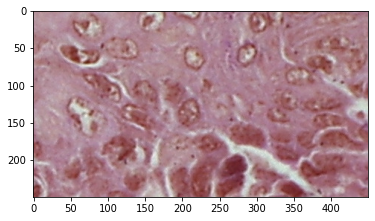

In [91]:
plt.imshow(img.data.cpu().permute(1, 2, 0).numpy())